In [2]:
import numpy as np
import pandas as pd

from multiprocessing import Pool

from spacepy import pycdf
from datetime import datetime, timedelta
import bisect
import scipy
from scipy import signal
from scipy import interpolate
import spacepy.datamodel as dm
import h5py

import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('seaborn')
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import lgw_functions as lgw

In [3]:
class Santolik_dataHolder:
    def __init__(self, freqs, S_Bx, S_By, S_Bz, fs):
        self.freqs = freqs
        self.S_Bx  = S_Bx
        self.S_By  = S_By
        self.S_Bz  = S_Bz
        self.fs    = fs
        
    def runAnalysis_onTimestep(self, tidx):
        return lgw.santolik_B(self.freqs, self.S_Bx, self.S_By, self.S_Bz, self.fs, tidx);
    # the function lgw.santolik_B in lgw_functions.py contains the SVD method, 
    # so this is where you would replace it with the 6 component method

/usr/local/lib/python3.7/site-packages/spacepy/datamodel.py:1506: UserWarning: Key DateTime for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)
/usr/local/lib/python3.7/site-packages/spacepy/datamodel.py:1506: UserWarning: Key ExtModel for conversion not found in file
  warnings.warn('Key {0} for conversion not found in file'.format(conkey), UserWarning)
/Users/alexandrawold/Documents/cu-boulder/research/for riley/lgw_functions.py:433: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.abs(np.arctan(np.sqrt(k1**2 + k2**2)/k3))
/Users/alexandrawold/Documents/cu-boulder/research/for riley/lgw_functions.py:433: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.abs(np.arctan(np.sqrt(k1**2 + k2**2)/k3))
/Users/alexandrawold/Documents/cu-boulder/research/for riley/lgw_functions.py:433: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.abs(np.arctan(np.sq

done


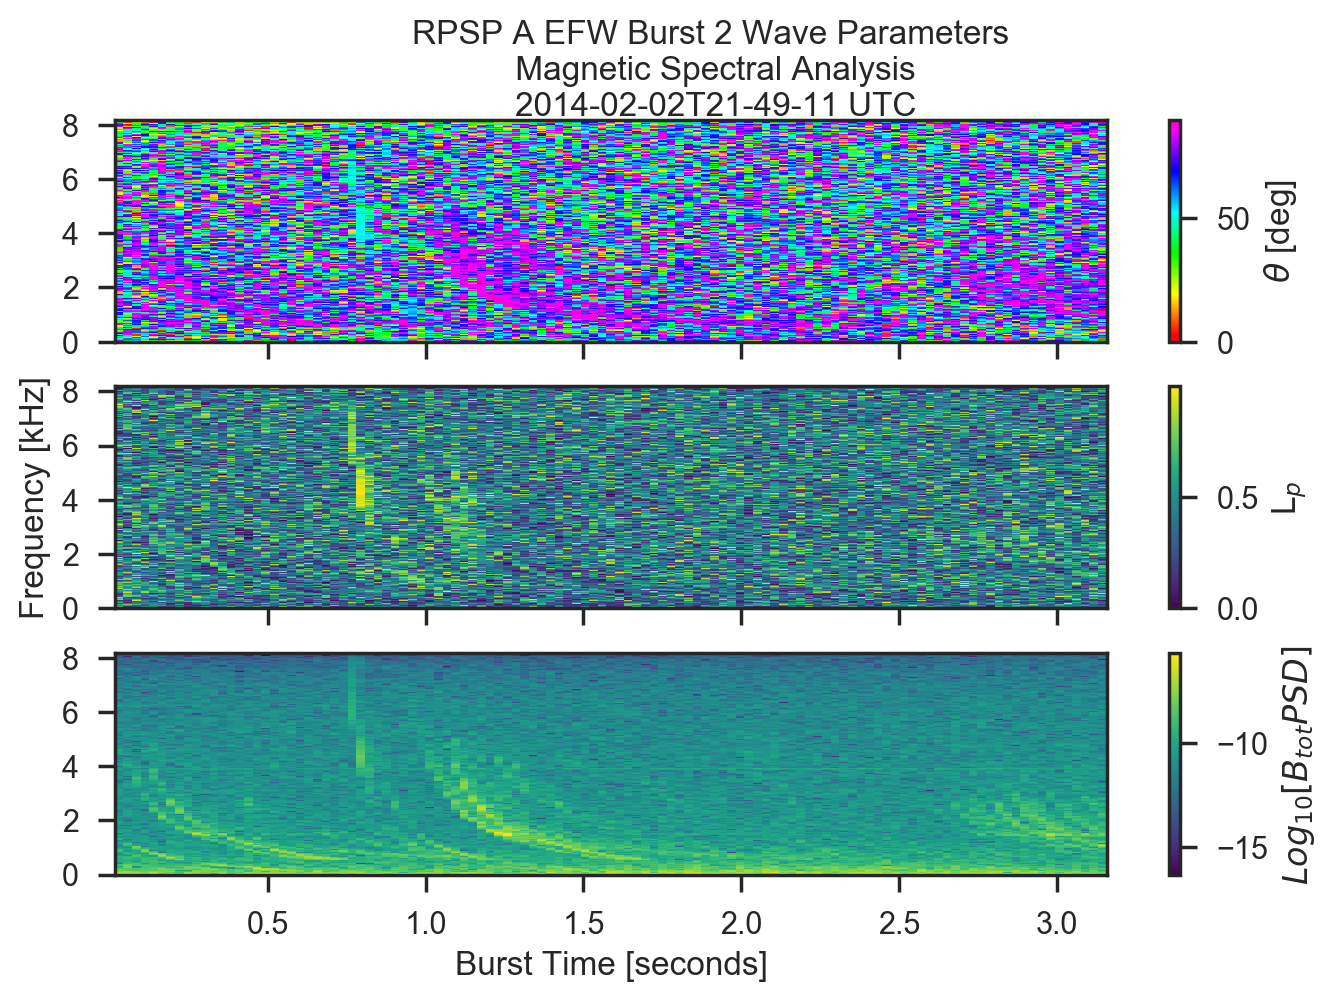

In [6]:
# Start and end time of sample EFW burst
efw_start = '2014-02-02 21:49:11'
efw_end = '2014-02-02 21:49:15'

burst_start = datetime.strptime(efw_start, '%Y-%m-%d %H:%M:%S')
burst_stop = datetime.strptime(efw_end, '%Y-%m-%d %H:%M:%S')

file_time = burst_start.strftime('%Y-%m-%dT%H-%M-%S')

# Save a file for a single burst from the full day of bursts (includes unit conversions)
lgw.newBurstFiles('rbspa_l1_vb2_20140202_v02.cdf', 
                  'rbspa_l1_mscb2_20140202_v02.cdf',
                  burst_start, 
                  burst_stop, 
                  file_time)

# Open burst file - this file contains just the data for the burst that I pulled out of the full day files
fn = 'b2_data_'+file_time
data = dm.readJSONheadedASCII(fn, convert=True)

# Convert potential into electric field
Eu = (data['V1'] - data['V2'])/(100)  
Ev = (data['V3'] - data['V4'])/(100)  
Ew = (data['V5'] - data['V6'])/(100)

# Interpolate data to correct ADC sampling time delays - you will need to do this for the E data too
Bt = pd.to_datetime(data['Bt'])

Bu = data['Bu'] 
Bu_t = Bt + timedelta(microseconds=(7*3.81))
tu = np.asarray([t.timestamp() for t in Bu_t])
tck_u = interpolate.splrep(tu, Bu)

Bv = data['Bv'] 
Bv_t = Bt + timedelta(microseconds=(8*3.81))
tv = np.asarray([t.timestamp() for t in Bv_t])
tck_v = interpolate.splrep(tv, Bv)

Bw = data['Bw']
Bw_t = Bt + timedelta(microseconds=(9*3.81))
tw = np.asarray([t.timestamp() for t in Bw_t])
tck_w = interpolate.splrep(tw, Bw)

tnew = [t.timestamp() for t in Bt] 
Bunew = interpolate.splev(tnew, tck_u)
Bvnew = interpolate.splev(tnew, tck_v)
Bwnew = interpolate.splev(tnew, tck_w)
tnew_dt = np.asarray([datetime.fromtimestamp(t) for t in tnew])

# load magnetometer data (background magnetic field)
date = burst_start.strftime('%Y%m%d')
fn_magnetometer = 'rbsp-a_magnetometer_uvw_emfisis-L2_'+date+'_v1.6.2.cdf'
cdf_magnetometer = pycdf.CDF(fn_magnetometer)

# grab just the magnetometer data that overlaps with the burst data
start = datetime.strptime(efw_start, '%Y-%m-%d %H:%M:%S')
stop = burst_start+timedelta(seconds=4)

Epoch = cdf_magnetometer['Epoch']
start_ind = bisect.bisect_left(Epoch, Bt[0])#start)
stop_ind = bisect.bisect_right(Epoch, Bt[-1])#stop)
Mag = cdf_magnetometer['Mag']
tvec_Mag = Epoch

# create rotation matrices to rotate data into field aligned frame
M = lgw.rotation_matrices(Mag[start_ind:stop_ind,:])    
# interpolate rotation matrices to burst time scale
M_interp, x, xnew = lgw.intepolateM(Bt, Epoch[start_ind:stop_ind], M)
# rotate B and E to field aligned frame
B_aligned, E_aligned = lgw.newAlignedFiles(M_interp, M_interp,
                                           Bunew, Bvnew, Bwnew, Eu[:(len(Bunew))], Ev[:(len(Bunew))], Ew[:(len(Bunew))])

# fft - get the complex (Sxx) and total PSD
fs = 16384
f_Bx, t_Bx, Sxx_Bx, PSD_Bx = lgw.get_fft(B_aligned[:,0], fs)
f_By, t_By, Sxx_By, PSD_By = lgw.get_fft(B_aligned[:,1], fs)
f_Bz, t_Bz, Sxx_Bz, PSD_Bz = lgw.get_fft(B_aligned[:,2], fs)
f_Btot, t_Btot, Sxx_Btot, PSD_Btot = lgw.get_fft(np.linalg.norm(B_aligned, axis=1), fs)


## Run Spectral Analysis ##

# Load data into object for analysis
santObject = Santolik_dataHolder(f_Bx, Sxx_Bx, Sxx_By, Sxx_Bz, fs);

# Loop through time steps
with Pool(processes=4) as pool:
    tidx = range(0, len(t_Bx))

    # Run analysis (frequencies looped through in this function)
    results_array = pool.map(santObject.runAnalysis_onTimestep, tidx);

    # Pack into numpy array
    results_array = np.array(results_array);

    # Update result arrays
    theta_all = results_array[:,1,:]
    phi_all   = results_array[:,2,:]
    F_all     = results_array[:,3,:]
    Lp_all    = results_array[:,4,:]
    Smag_all  = results_array[:,5,:]
    
print('done')

# Save final results to file
data = dm.SpaceData()
data['f_Bx'] = f_Bx
data['t_Bx'] = t_Bx
data['theta_all'] = np.real(theta_all)
data['phi_all'] = np.real(phi_all)
data['F_all'] = np.real(F_all)
data['Lp_all'] = np.real(Lp_all)
data['Smag_all'] = Smag_all
data['PSD_Btot'] = PSD_Btot
# save_fn = 'efw_spectral_analysis/output_files/'+file_time+'_santolik_B_output'
# dm.toJSONheadedASCII(save_fn, data)

# Plot the results!
sns.set(style="ticks")

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 5), sharex=True)

X = t_Bx
Y = f_Bx/1e3

c = ax0.pcolor(X, Y, np.rad2deg(data['theta_all'].T), cmap='gist_rainbow')
ax0.set_yticks(np.arange(min(Y), max(Y)+1, 2.0))
cb = fig.colorbar(c, ax=ax0)
cb.set_label(r'$\theta$ [deg]')

c = ax1.pcolor(X, Y, data['Lp_all'].T, cmap='viridis')
ax1.set_yticks(np.arange(min(Y), max(Y)+1, 2.0))
ax1.set_ylabel('Frequency [kHz]')
cb = fig.colorbar(c, ax=ax1)
cb.set_label(r'L$_p$')

c = ax2.pcolor(X, Y, np.log10(data['PSD_Btot']), cmap='viridis')
ax2.set_yticks(np.arange(min(Y), max(Y)+1, 2.0))
cb = fig.colorbar(c, ax=ax2)
cb.set_label(r'$Log_{10}[B_{tot} PSD]$ ')
ax2.set_xlabel('Burst Time [seconds]')

title = 'RPSP A EFW Burst 2 Wave Parameters \n Magnetic Spectral Analysis \n'+file_time+' UTC'
plt.suptitle(title, fontsize=12)

plt.show()